# Glass Boxes over Black Boxes
### An Empirical Study on Fairness in Criminal Justice AI

**Authors:** Vidhi Bhatt, Yuri Kim, Ashvin Loghashankar  
**Course:** CS 269 Fall 2025, UCLA

## Project Overview

This study compares interpretable models (Decision Trees, Logistic Regression) against black-box models (Random Forest, XGBoost) on the ProPublica COMPAS dataset, focusing on:

1. **Performance Comparison**: Accuracy, precision, recall, and F1-scores
2. **Fairness Analysis**: Disparate impact and error rate differences across racial groups  
3. **Bias Mitigation**: Feature removal and fairness-constrained training
4. **Causal Analysis**: Decomposing bias into data-driven vs algorithmic components

In [1]:
# Installing required packages for fairness analysis
!pip install fairlearn
!pip install shap
!pip install xgboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.6/251.6 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.3/37.3 MB 22.0 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.16.3
    Uninstalling scipy-1.16.3:
      Successfully uninstalled scipy-1.16.3


In [2]:
# Importing essential libraries for data analysis and machine learning
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Importing scikit-learn modules for model training and evaluation
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report

# Importing fairness libraries for bias mitigation
from fairlearn.reductions import GridSearch, EqualizedOdds, DemographicParity
from fairlearn.postprocessing import ThresholdOptimizer
from fairlearn.metrics import demographic_parity_difference, equalized_odds_difference, false_positive_rate, false_negative_rate

# Importing statistical analysis tools
from scipy.stats import chi2_contingency, pointbiserialr, ttest_ind
import warnings
warnings.filterwarnings('ignore')

# Setting up visualization parameters
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 7)

In [4]:
# Loading the ProPublica COMPAS dataset for fairness analysis
df = pd.read_csv('propublica_data_for_fairml.csv')

In [5]:
# Performing basic exploratory data analysis
print(df.describe())

# Examining the distribution of our target variable (recidivism)
print(df['Two_yr_Recidivism'].value_counts())
print(f"\nRecidivism Rate: {df['Two_yr_Recidivism'].mean():.2%}")

       Two_yr_Recidivism  Number_of_Priors  score_factor  \
count        6172.000000       6172.000000   6172.000000   
mean            0.455120          3.246436      0.445723   
std             0.498022          4.743770      0.497086   
min             0.000000          0.000000      0.000000   
25%             0.000000          0.000000      0.000000   
50%             0.000000          1.000000      0.000000   
75%             1.000000          4.000000      1.000000   
max             1.000000         38.000000      1.000000   

       Age_Above_FourtyFive  Age_Below_TwentyFive  African_American  \
count           6172.000000           6172.000000       6172.000000   
mean               0.209494              0.218244          0.514420   
std                0.406981              0.413087          0.499833   
min                0.000000              0.000000          0.000000   
25%                0.000000              0.000000          0.000000   
50%                0.000000      

In [6]:
# Analyzing demographic distribution in the dataset
demographic_cols = ['African_American', 'Asian', 'Hispanic', 'Native_American', 'Other', 'Female']

for col in demographic_cols:
    print(f"{col}: {df[col].sum()} ({df[col].mean():.2%})")

# Creating a consolidated race variable for easier analysis
df['race'] = 'Other'
df.loc[df['African_American'] == 1, 'race'] = 'African American'
df.loc[df['Asian'] == 1, 'race'] = 'Asian'
df.loc[df['Hispanic'] == 1, 'race'] = 'Hispanic'
df.loc[df['Native_American'] == 1, 'race'] = 'Native American'

print(f"\nRace Distribution from data:")
print(df['race'].value_counts())

African_American: 3175 (51.44%)
Asian: 31 (0.50%)
Hispanic: 509 (8.25%)
Native_American: 11 (0.18%)
Other: 343 (5.56%)
Female: 1175 (19.04%)

Race Distribution from data:
race
African American    3175
Other               2446
Hispanic             509
Asian                 31
Native American       11
Name: count, dtype: int64


Recidivism by Race:
                  Recidivists  Total  Recidivism_Rate
race                                                 
African American         1661   3175         0.523150
Asian                       8     31         0.258065
Hispanic                  189    509         0.371316
Native American             5     11         0.454545
Other                     946   2446         0.386754


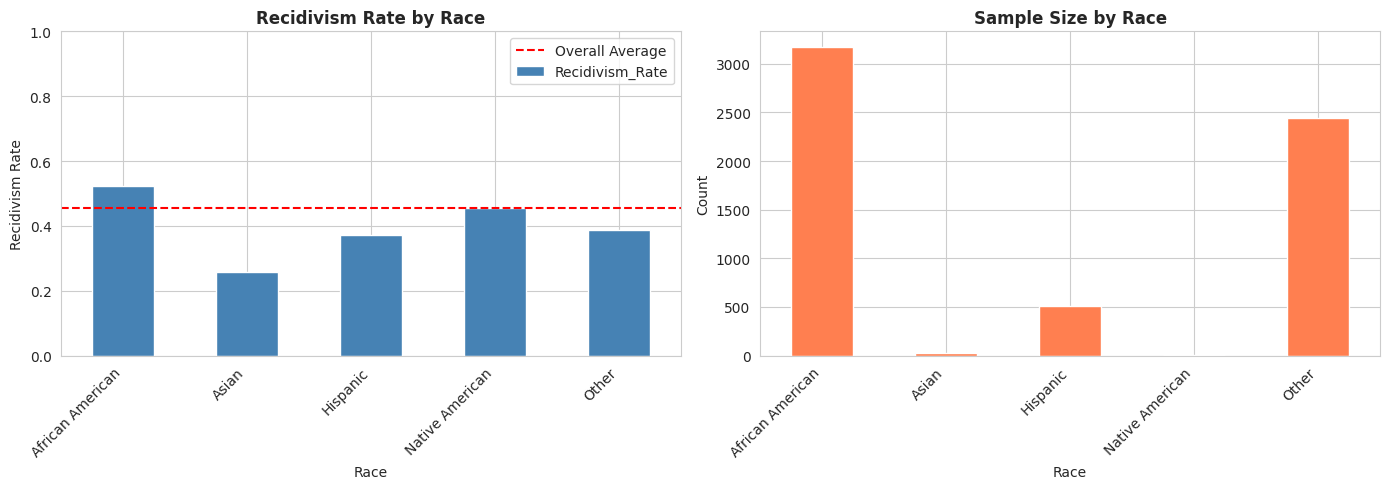

In [7]:
# Calculating recidivism rates by racial group to identify disparities
recidivism_by_race = df.groupby('race')['Two_yr_Recidivism'].agg(['sum', 'count', 'mean'])
recidivism_by_race.columns = ['Recidivists', 'Total', 'Recidivism_Rate']
print("Recidivism by Race:")
print(recidivism_by_race)

# Visualizing racial disparities in recidivism rates
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

recidivism_by_race['Recidivism_Rate'].plot(kind='bar', ax=ax[0], color='steelblue')
ax[0].set_title('Recidivism Rate by Race', fontsize=12, fontweight='bold')
ax[0].set_ylabel('Recidivism Rate')
ax[0].set_xlabel('Race')
ax[0].set_ylim([0, 1])
ax[0].axhline(y=df['Two_yr_Recidivism'].mean(), color='red', linestyle='--', label='Overall Average')
ax[0].legend()
plt.setp(ax[0].xaxis.get_majorticklabels(), rotation=45, ha='right')

recidivism_by_race['Total'].plot(kind='bar', ax=ax[1], color='coral')
ax[1].set_title('Sample Size by Race', fontsize=12, fontweight='bold')
ax[1].set_ylabel('Count')
ax[1].set_xlabel('Race')
plt.setp(ax[1].xaxis.get_majorticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

In [8]:
# Preparing features and target variables for machine learning
X = df.drop(['Two_yr_Recidivism', 'race'], axis=1)
y = df['Two_yr_Recidivism']
sensitive_attr = df['African_American']  # 1 = African American, 0 = Other

# Splitting data while maintaining class balance
X_train, X_test, y_train, y_test, sens_train, sens_test = train_test_split(
    X, y, sensitive_attr, test_size=0.3, random_state=42, stratify=y
)

In [9]:
# Standardizing features for algorithms sensitive to scale
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [10]:
# Training our first interpretable model - Decision Tree
dt_model = DecisionTreeClassifier(max_depth=5, random_state=42, min_samples_split=20)
dt_model.fit(X_train, y_train)
# Generating predictions for evaluation
dt_pred = dt_model.predict(X_test)
dt_pred_proba = dt_model.predict_proba(X_test)[:, 1]

# Examining model complexity
print(f"Tree Depth: {dt_model.get_depth()}")
print(f"Number of Leaves: {dt_model.get_n_leaves()}")

Tree Depth: 5
Number of Leaves: 30


In [11]:
# Training our second interpretable model - Logistic Regression
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train_scaled, y_train)
# Generating predictions for evaluation
lr_pred = lr_model.predict(X_test_scaled)
lr_pred_proba = lr_model.predict_proba(X_test_scaled)[:, 1]

# Examining feature coefficients to understand model decisions
coef_df = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': lr_model.coef_[0]
}).sort_values('Coefficient', ascending=False)
print(coef_df)

                 Feature  Coefficient
0       Number_of_Priors     0.596545
1           score_factor     0.364085
3   Age_Below_TwentyFive     0.206868
8                  Other     0.008456
7        Native_American    -0.005390
4       African_American    -0.012557
5                  Asian    -0.048261
6               Hispanic    -0.067755
10           Misdemeanor    -0.131940
9                 Female    -0.157924
2   Age_Above_FourtyFive    -0.190544


In [12]:
# Training our first black box model - Random Forest
rf_model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)
# Generating predictions for evaluation
rf_pred = rf_model.predict(X_test)
rf_pred_proba = rf_model.predict_proba(X_test)[:, 1]

In [13]:
# Training our second black box model - XGBoost
xgb_model = XGBClassifier(n_estimators=100, max_depth=5, random_state=42, verbosity=0)
xgb_model.fit(X_train, y_train)
# Generating predictions for evaluation
xgb_pred = xgb_model.predict(X_test)
xgb_pred_proba = xgb_model.predict_proba(X_test)[:, 1]

In [14]:
# Computing standard performance metrics for all models
def compute_metrics(y_true, y_pred, model_name):
    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)

    return {
        'Model': model_name,
        'Accuracy': accuracy,
        'F1-Score': f1,
        'Precision': precision,
        'Recall': recall
    }

# Evaluating all trained models
metrics_list = [
    compute_metrics(y_test, dt_pred, 'Decision Tree'),
    compute_metrics(y_test, lr_pred, 'Logistic Regression'),
    compute_metrics(y_test, rf_pred, 'Random Forest'),
    compute_metrics(y_test, xgb_pred, 'XGBoost')
]

metrics_df = pd.DataFrame(metrics_list)
print("\nAccuracy metrics:")
print(metrics_df.to_string(index=False))


Accuracy metrics:
              Model  Accuracy  F1-Score  Precision   Recall
      Decision Tree  0.677646  0.621433   0.667575 0.581257
Logistic Regression  0.684125  0.623794   0.681180 0.575326
      Random Forest  0.672246  0.614113   0.661644 0.572954
            XGBoost  0.675486  0.609487   0.673851 0.556346


### Fairness Metrics

This section evaluates algorithmic bias by measuring disparate impact ratios and error rate differences across racial groups. We focus on three key metrics:
- **Disparate Impact**: Ratio of positive prediction rates between African Americans and other races
- **False Positive Rate (FPR) Difference**: Difference in incorrectly flagging low-risk individuals
- **False Negative Rate (FNR) Difference**: Difference in missing high-risk individuals

In [15]:
# Computing fairness metrics to assess algorithmic bias
# sensitive_attr: 1 = African American, 0 = Other
def compute_fairness_metrics(y_true, y_pred, sensitive_attr, model_name):
    # Calculating ratio of positive predictions for African Americans vs Others
    aa_positive_rate = y_pred[sensitive_attr == 1].mean()
    other_positive_rate = y_pred[sensitive_attr == 0].mean()
    disparate_impact = aa_positive_rate / (other_positive_rate + 1e-6)

    # Computing False Positive Rate differences
    aa_fpr = false_positive_rate(y_true[sensitive_attr == 1], y_pred[sensitive_attr == 1])
    other_fpr = false_positive_rate(y_true[sensitive_attr == 0], y_pred[sensitive_attr == 0])
    fpr_difference = aa_fpr - other_fpr

    # Computing False Negative Rate differences
    aa_fnr = false_negative_rate(y_true[sensitive_attr == 1], y_pred[sensitive_attr == 1])
    other_fnr = false_negative_rate(y_true[sensitive_attr == 0], y_pred[sensitive_attr == 0])
    fnr_difference = aa_fnr - other_fnr

    return {
        'Model': model_name,
        'AA_Positive_Rate': aa_positive_rate,
        'Other_Positive_Rate': other_positive_rate,
        'Disparate_Impact_Ratio': disparate_impact,
        'AA_FPR': aa_fpr,
        'Other_FPR': other_fpr,
        'FPR_Difference': fpr_difference,
        'AA_FNR': aa_fnr,
        'Other_FNR': other_fnr,
        'FNR_Difference': fnr_difference
    }

# Evaluating fairness across all trained models
fairness_list = [
    compute_fairness_metrics(y_test, dt_pred, sens_test, 'Decision Tree'),
    compute_fairness_metrics(y_test, lr_pred, sens_test, 'Logistic Regression'),
    compute_fairness_metrics(y_test, rf_pred, sens_test, 'Random Forest'),
    compute_fairness_metrics(y_test, xgb_pred, sens_test, 'XGBoost')
]

fairness_df = pd.DataFrame(fairness_list)
print("\nFairness Metrics:")
print(fairness_df.to_string(index=False))


Fairness Metrics:
              Model  AA_Positive_Rate  Other_Positive_Rate  Disparate_Impact_Ratio   AA_FPR  Other_FPR  FPR_Difference   AA_FNR  Other_FNR  FNR_Difference
      Decision Tree          0.512552             0.272321                1.882152 0.339326   0.164894        0.174432 0.336595   0.545181       -0.208586
Logistic Regression          0.517782             0.242188                2.137932 0.330337   0.141844        0.188493 0.318982   0.587349       -0.268367
      Random Forest          0.521967             0.257812                2.024590 0.355056   0.157801        0.197255 0.332681   0.572289       -0.239608
            XGBoost          0.491632             0.252232                1.949117 0.325843   0.145390        0.180453 0.363992   0.566265       -0.202273


In [16]:
# Comparing interpretable vs black-box models on accuracy and fairness
print(f"\nInterpretable Models Average Accuracy: {metrics_df[metrics_df['Model'].isin(['Decision Tree', 'Logistic Regression'])]['Accuracy'].mean():.4f}")
print(f"Black-Box Models Average Accuracy: {metrics_df[metrics_df['Model'].isin(['Random Forest', 'XGBoost'])]['Accuracy'].mean():.4f}")
print(f"\nInterpretable Models Average Disparate Impact: {fairness_df[fairness_df['Model'].isin(['Decision Tree', 'Logistic Regression'])]['Disparate_Impact_Ratio'].mean():.4f}")
print(f"Black-Box Models Average Disparate Impact: {fairness_df[fairness_df['Model'].isin(['Random Forest', 'XGBoost'])]['Disparate_Impact_Ratio'].mean():.4f}")


Interpretable Models Average Accuracy: 0.6809
Black-Box Models Average Accuracy: 0.6739

Interpretable Models Average Disparate Impact: 2.0100
Black-Box Models Average Disparate Impact: 1.9869


In [17]:
# Conducting ablation study to understand feature impact on fairness
def fairness_metric(y_true, y_pred, sensitive_attr):
    aa_positive_rate = y_pred[sensitive_attr == 1].mean()
    other_positive_rate = y_pred[sensitive_attr == 0].mean()
    disparate_impact = aa_positive_rate / (other_positive_rate + 1e-6)
    return disparate_impact

ablation_results = []

# Establishing baseline performance with all features
lr_baseline = LogisticRegression(max_iter=1000, random_state=42)
lr_baseline.fit(X_train_scaled, y_train)
baseline_pred = lr_baseline.predict(X_test_scaled)
baseline_di = fairness_metric(y_test, baseline_pred, sens_test)
baseline_acc = accuracy_score(y_test, baseline_pred)

ablation_results.append({
    'Configuration': 'Baseline (All Features)',
    'Features_Removed': 'None',
    'Num_Features': X_train.shape[1],
    'Disparate_Impact': baseline_di,
    'Accuracy': baseline_acc,
    'DI_Improvement': 0,
    'Accuracy_Loss': 0
})
print("Impact of Removing Features on Disparate Impact")
print(f"\nBaseline (All Features):")
print(f"  Disparate Impact: {baseline_di:.4f}")
print(f"  Accuracy: {baseline_acc:.4f}")

# Testing impact of removing each feature individually
for feature_to_remove in X_train.columns:
    X_train_removed = X_train.drop(feature_to_remove, axis=1)
    X_test_removed = X_test.drop(feature_to_remove, axis=1)

    # Retraining model without the selected feature
    scaler_temp = StandardScaler()
    X_train_temp = scaler_temp.fit_transform(X_train_removed)
    X_test_temp = scaler_temp.transform(X_test_removed)

    lr_temp = LogisticRegression(max_iter=1000, random_state=42)
    lr_temp.fit(X_train_temp, y_train)
    temp_pred = lr_temp.predict(X_test_temp)

    # Measuring changes in fairness and accuracy
    temp_di = fairness_metric(y_test, temp_pred, sens_test)
    temp_acc = accuracy_score(y_test, temp_pred)

    di_improvement = baseline_di - temp_di
    acc_loss = baseline_acc - temp_acc

    ablation_results.append({
        'Configuration': f'Remove: {feature_to_remove}',
        'Features_Removed': feature_to_remove,
        'Num_Features': X_train_removed.shape[1],
        'Disparate_Impact': temp_di,
        'Accuracy': temp_acc,
        'DI_Improvement': di_improvement,
        'Accuracy_Loss': acc_loss
    })

ablation_df = pd.DataFrame(ablation_results).sort_values('DI_Improvement', ascending=False)

print(ablation_df.to_string(index=False))

Impact of Removing Features on Disparate Impact

Baseline (All Features):
  Disparate Impact: 2.1379
  Accuracy: 0.6841
               Configuration     Features_Removed  Num_Features  Disparate_Impact  Accuracy  DI_Improvement  Accuracy_Loss
    Remove: Number_of_Priors     Number_of_Priors            10          2.031988  0.663607        0.105943       0.020518
              Remove: Female               Female            10          2.099406  0.683585        0.038526       0.000540
     Remove: Native_American      Native_American            10          2.128125  0.683585        0.009807       0.000540
     Baseline (All Features)                 None            11          2.137932  0.684125        0.000000       0.000000
               Remove: Other                Other            10          2.137932  0.684125        0.000000       0.000000
         Remove: Misdemeanor          Misdemeanor            10          2.178203  0.677646       -0.040271       0.006479
Remove: Age_Above_F

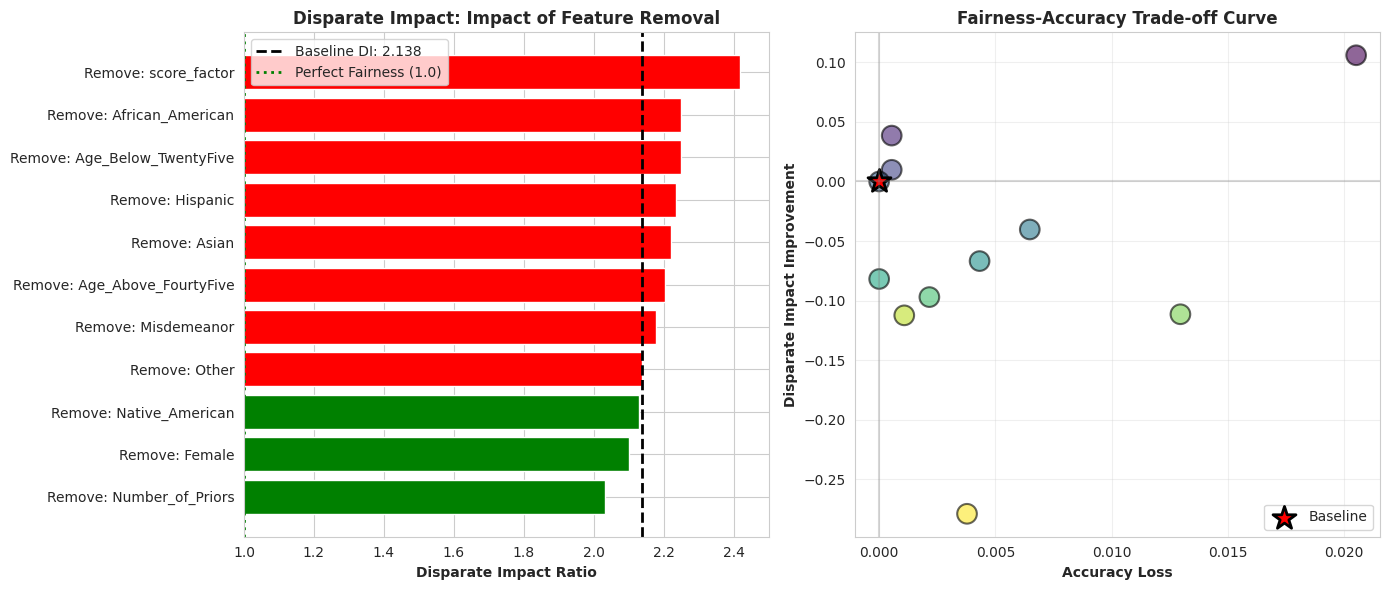

In [18]:
# Visualizing the fairness-accuracy trade-offs from ablation study
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

ablation_sorted = ablation_df[ablation_df['Configuration'] != 'Baseline (All Features)'].sort_values('Disparate_Impact')
colors = ['green' if x < baseline_di else 'red' for x in ablation_sorted['Disparate_Impact']]
axes[0].barh(ablation_sorted['Configuration'], ablation_sorted['Disparate_Impact'], color=colors)
axes[0].axvline(x=baseline_di, color='black', linestyle='--', linewidth=2, label=f'Baseline DI: {baseline_di:.3f}')
axes[0].axvline(x=1.0, color='green', linestyle=':', linewidth=2, label='Perfect Fairness (1.0)')
axes[0].set_xlabel('Disparate Impact Ratio', fontweight='bold')
axes[0].set_title('Disparate Impact: Impact of Feature Removal', fontweight='bold')
axes[0].legend()
axes[0].set_xlim([1, 2.5])

ablation_for_plot = ablation_df[ablation_df['Configuration'] != 'Baseline (All Features)']
scatter = axes[1].scatter(ablation_for_plot['Accuracy_Loss'],
                          ablation_for_plot['DI_Improvement'],
                          s=200, alpha=0.6, c=range(len(ablation_for_plot)),
                          cmap='viridis', edgecolors='black', linewidth=1.5)
axes[1].scatter([0], [0], s=300, marker='*', c='red', edgecolors='black', linewidth=2, label='Baseline')
axes[1].axhline(y=0, color='gray', linestyle='-', alpha=0.3)
axes[1].axvline(x=0, color='gray', linestyle='-', alpha=0.3)
axes[1].set_xlabel('Accuracy Loss', fontweight='bold')
axes[1].set_ylabel('Disparate Impact Improvement', fontweight='bold')
axes[1].set_title('Fairness-Accuracy Trade-off Curve', fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [19]:
# Implementing fairness-constrained training approaches
print("Fairness-constrained training")

# Applying Demographic Parity constraint (Equal positive rates across groups)
print("\n1. DEMOGRAPHIC PARITY CONSTRAINT")
print("   Goal: Equal prediction rates across racial groups")
print("   Constraint: P(Y_pred=1|AA=1) = P(Y_pred=1|AA=0)")

# Training model with demographic parity constraint
constraint_dp = DemographicParity(difference_bound=0.1)
mitigator_dp = GridSearch(
    LogisticRegression(max_iter=1000, random_state=42),
    constraints=constraint_dp,
    grid_size=50
)

mitigator_dp.fit(X_train_scaled, y_train, sensitive_features=sens_train)
dp_pred = mitigator_dp.predict(X_test_scaled)

# Evaluating constrained model performance
dp_accuracy = accuracy_score(y_test, dp_pred)
dp_di = fairness_metric(y_test, dp_pred, sens_test)

print(f"\nResults with Demographic Parity:")
print(f"  Accuracy: {dp_accuracy:.4f} (vs baseline {baseline_acc:.4f}, change: {dp_accuracy-baseline_acc:.4f})")
print(f"  Disparate Impact: {dp_di:.4f} (vs baseline {baseline_di:.4f}, improvement: {baseline_di-dp_di:.4f})")
dp_applied = True

Fairness-constrained training

1. DEMOGRAPHIC PARITY CONSTRAINT
   Goal: Equal prediction rates across racial groups
   Constraint: P(Y_pred=1|AA=1) = P(Y_pred=1|AA=0)

Results with Demographic Parity:
  Accuracy: 0.6782 (vs baseline 0.6841, change: -0.0059)
  Disparate Impact: 1.1776 (vs baseline 2.1379, improvement: 0.9603)


In [20]:
# Applying Equalized Odds constraint (Equal error rates across groups)
print("\n2. Equalized Odds constraint")
print("   Goal: Equal false positive and false negative rates across groups")
print("   Constraints: FPR_AA = FPR_Other AND FNR_AA = FNR_Other")

# Training model with equalized odds constraint
constraint_eo = EqualizedOdds(difference_bound=0.1)
mitigator_eo = GridSearch(
    LogisticRegression(max_iter=1000, random_state=42),
    constraints=constraint_eo,
    grid_size=50
)

mitigator_eo.fit(X_train_scaled, y_train, sensitive_features=sens_train)
eo_pred = mitigator_eo.predict(X_test_scaled)

# Evaluating equalized odds model performance
eo_accuracy = accuracy_score(y_test, eo_pred)
eo_di = fairness_metric(y_test, eo_pred, sens_test)

print(f"\nResults with Equalized Odds:")
print(f"  Accuracy: {eo_accuracy:.4f} (vs baseline {baseline_acc:.4f}, change: {eo_accuracy-baseline_acc:.4f})")
print(f"  Disparate Impact: {eo_di:.4f} (vs baseline {baseline_di:.4f}, improvement: {baseline_di-eo_di:.4f})")
eo_applied = True


2. Equalized Odds constraint
   Goal: Equal false positive and false negative rates across groups
   Constraints: FPR_AA = FPR_Other AND FNR_AA = FNR_Other

Results with Equalized Odds:
  Accuracy: 0.6582 (vs baseline 0.6841, change: -0.0259)
  Disparate Impact: 1.0879 (vs baseline 2.1379, improvement: 1.0501)


In [21]:
# Comparing effectiveness of different fairness interventions
intervention_results = [
    {
        'Intervention': 'Baseline (No Constraints)',
        'Accuracy': baseline_acc,
        'Disparate_Impact': baseline_di,
        'Accuracy_Loss': 0,
        'Fairness_Gain': 0,
        'Efficiency_Ratio': np.inf
    }
]

# Recording demographic parity results if applied
if dp_applied and dp_accuracy is not None:
    intervention_results.append({
        'Intervention': 'Demographic Parity Constraint',
        'Accuracy': dp_accuracy,
        'Disparate_Impact': dp_di,
        'Accuracy_Loss': baseline_acc - dp_accuracy,
        'Fairness_Gain': baseline_di - dp_di,
        'Efficiency_Ratio': (baseline_di - dp_di) / max(baseline_acc - dp_accuracy, 0.0001)
    })

# Recording equalized odds results if applied
if eo_applied and eo_accuracy is not None:
    intervention_results.append({
        'Intervention': 'Equalized Odds Constraint',
        'Accuracy': eo_accuracy,
        'Disparate_Impact': eo_di,
        'Accuracy_Loss': baseline_acc - eo_accuracy,
        'Fairness_Gain': baseline_di - eo_di,
        'Efficiency_Ratio': (baseline_di - eo_di) / max(baseline_acc - eo_accuracy, 0.0001)
    })

intervention_df = pd.DataFrame(intervention_results)
print("\n" + intervention_df.to_string(index=False))


                 Intervention  Accuracy  Disparate_Impact  Accuracy_Loss  Fairness_Gain  Efficiency_Ratio
    Baseline (No Constraints)  0.684125          2.137932       0.000000       0.000000               inf
Demographic Parity Constraint  0.678186          1.177631       0.005940       0.960301        161.679745
    Equalized Odds Constraint  0.658207          1.087863       0.025918       1.050068         40.515136


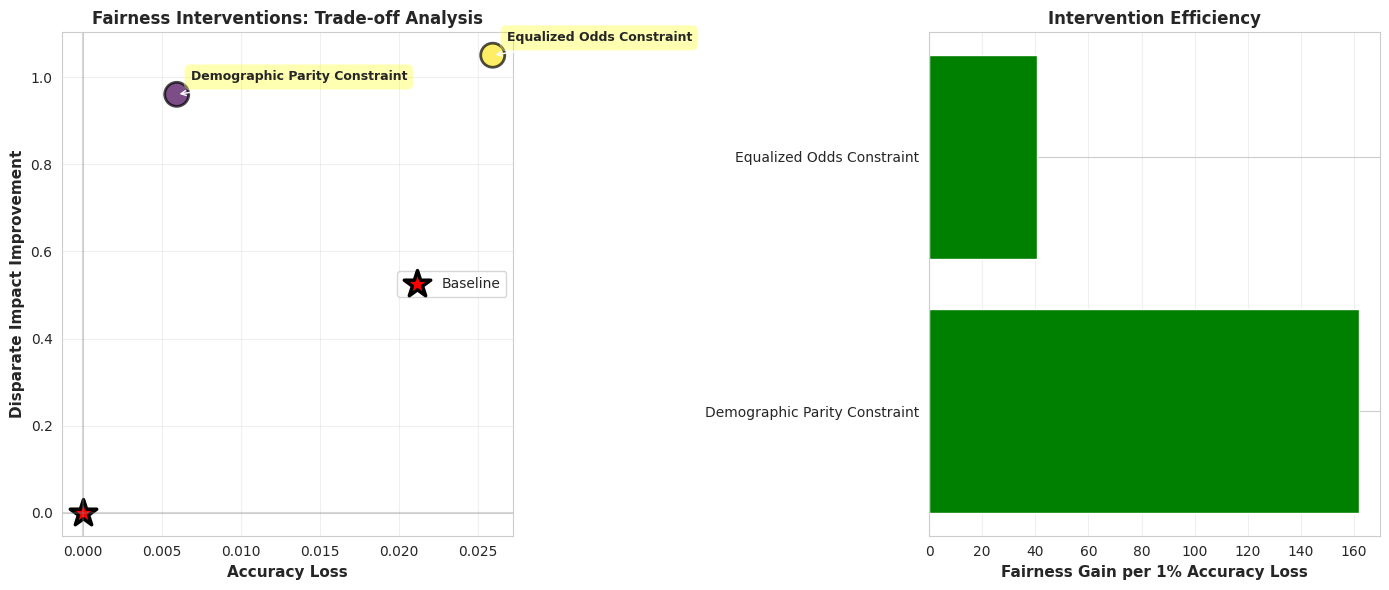

In [22]:
# Plotting
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

intervention_plot = intervention_df[intervention_df['Intervention'] != 'Baseline (No Constraints)']
scatter = axes[0].scatter(intervention_plot['Accuracy_Loss'],
                          intervention_plot['Fairness_Gain'],
                          s=300, alpha=0.7, c=range(len(intervention_plot)),
                          cmap='viridis', edgecolors='black', linewidth=2)
axes[0].scatter([0], [0], s=400, marker='*', c='red', edgecolors='black', linewidth=2.5, label='Baseline')

for idx, row in intervention_plot.iterrows():
    axes[0].annotate(row['Intervention'],
                    (row['Accuracy_Loss'], row['Fairness_Gain']),
                    fontsize=9, fontweight='bold',
                    xytext=(10, 10), textcoords='offset points',
                    bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow', alpha=0.3),
                    arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))

axes[0].axhline(y=0, color='gray', linestyle='-', alpha=0.3)
axes[0].axvline(x=0, color='gray', linestyle='-', alpha=0.3)
axes[0].set_xlabel('Accuracy Loss', fontweight='bold', fontsize=11)
axes[0].set_ylabel('Disparate Impact Improvement', fontweight='bold', fontsize=11)
axes[0].set_title('Fairness Interventions: Trade-off Analysis', fontweight='bold', fontsize=12)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

intervention_eff = intervention_df[intervention_df['Efficiency_Ratio'] != np.inf].sort_values('Efficiency_Ratio', ascending=False)
colors_eff = ['green' if x > 0 else 'gray' for x in intervention_eff['Efficiency_Ratio']]
axes[1].barh(intervention_eff['Intervention'], intervention_eff['Efficiency_Ratio'], color=colors_eff)
axes[1].set_xlabel('Fairness Gain per 1% Accuracy Loss', fontweight='bold', fontsize=11)
axes[1].set_title('Intervention Efficiency', fontweight='bold', fontsize=12)
axes[1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

## Statistical Significance Testing

We use cross-validation and t-tests to determine whether observed performance differences between interpretable and black-box models are statistically meaningful or due to random variation.

In [23]:
# Performing cross-validation to assess model reliability
models_cv = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Decision Tree': DecisionTreeClassifier(max_depth=5, random_state=42, min_samples_split=20)
}

# Using stratified k-fold to maintain class balance across folds
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_results = {}

# Evaluating each model across multiple folds
for name, model in models_cv.items():
    scores = cross_val_score(model, X_train_scaled, y_train, cv=kfold, scoring='accuracy')
    cv_results[name] = scores
    print(f"\n{name}:")
    print(f"  Fold Scores: {[f'{s:.4f}' for s in scores]}")
    print(f"  Mean: {scores.mean():.4f}")
    print(f"  Std Dev: {scores.std():.4f}")
    print(f"  95% CI: [{scores.mean() - 1.96*scores.std()/np.sqrt(5):.4f}, {scores.mean() + 1.96*scores.std()/np.sqrt(5):.4f}]")


Logistic Regression:
  Fold Scores: ['0.6910', '0.6944', '0.6562', '0.6667', '0.6655']
  Mean: 0.6748
  Std Dev: 0.0151
  95% CI: [0.6615, 0.6880]

Decision Tree:
  Fold Scores: ['0.7095', '0.7130', '0.6736', '0.6933', '0.6690']
  Mean: 0.6917
  Std Dev: 0.0180
  95% CI: [0.6759, 0.7074]


In [24]:
# Conducting two-sample t-tests to compare model performance

model_names = list(cv_results.keys())
for i in range(len(model_names)):
    for j in range(i+1, len(model_names)):
        name1, name2 = model_names[i], model_names[j]
        scores1, scores2 = cv_results[name1], cv_results[name2]

        # Performing statistical test for significant differences
        t_stat, p_value = ttest_ind(scores1, scores2)

        print(f"\n{name1} vs {name2}:")
        print(f"  Mean Difference: {scores1.mean() - scores2.mean():.4f}")
        print(f"  t-statistic: {t_stat:.4f}")
        print(f"  p-value: {p_value:.4f}")

        # Interpreting statistical significance
        if p_value < 0.05:
            print(f"  Result: STATISTICALLY SIGNIFICANT (p < 0.05)")
            if scores1.mean() > scores2.mean():
                print(f"  - {name1} is significantly better")
            else:
                print(f"  - {name2} is significantly better")
        else:
            print(f"  Result: NOT statistically significant (p ≥ 0.05)")
            print(f"  - No significant difference between models")


Logistic Regression vs Decision Tree:
  Mean Difference: -0.0169
  t-statistic: -1.4389
  p-value: 0.1881
  Result: NOT statistically significant (p ≥ 0.05)
  - No significant difference between models


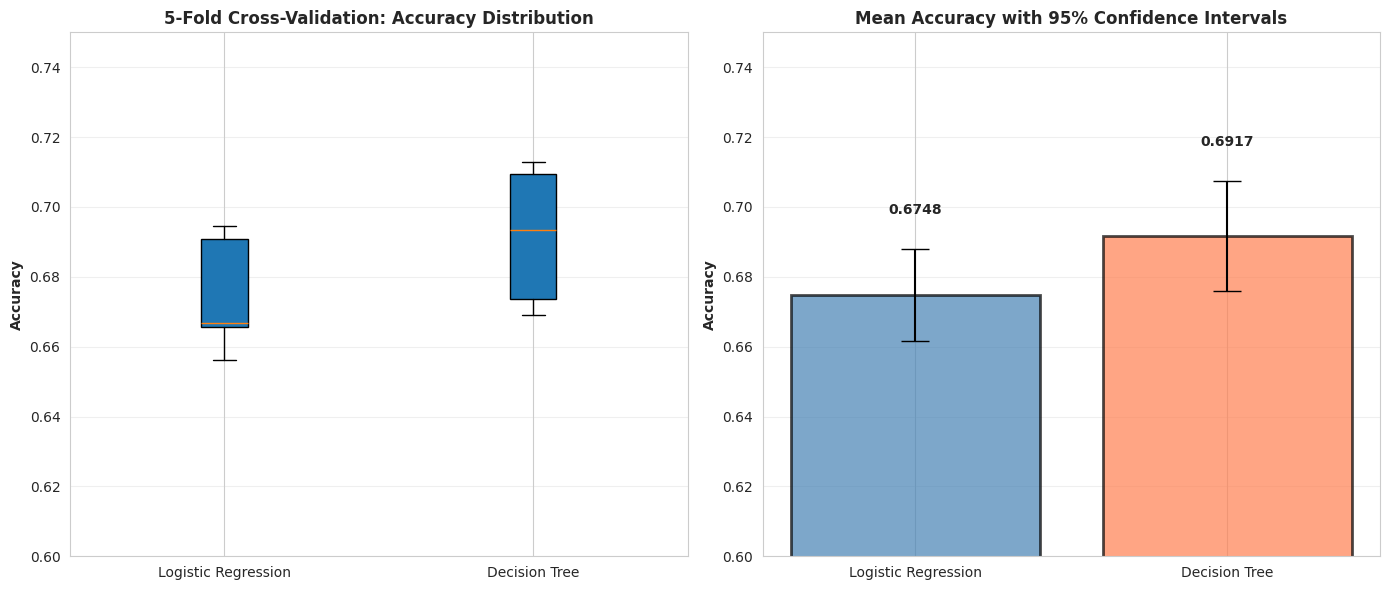

In [25]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

cv_data = [cv_results[name] for name in model_names]
axes[0].boxplot(cv_data, labels=model_names, patch_artist=True)
axes[0].set_ylabel('Accuracy', fontweight='bold')
axes[0].set_title('5-Fold Cross-Validation: Accuracy Distribution', fontweight='bold')
axes[0].set_ylim([0.6, 0.75])
axes[0].grid(True, alpha=0.3, axis='y')

means = [scores.mean() for scores in cv_data]
stds = [scores.std() for scores in cv_data]
ci_95 = [1.96 * std / np.sqrt(5) for std in stds]

axes[1].bar(model_names, means, yerr=ci_95, capsize=10, alpha=0.7,
           color=['steelblue', 'coral'], edgecolor='black', linewidth=2)
axes[1].set_ylabel('Accuracy', fontweight='bold')
axes[1].set_title('Mean Accuracy with 95% Confidence Intervals', fontweight='bold')
axes[1].set_ylim([0.6, 0.75])
axes[1].grid(True, alpha=0.3, axis='y')

for i, (mean, ci) in enumerate(zip(means, ci_95)):
    axes[1].text(i, mean + ci + 0.01, f'{mean:.4f}', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

## Causal Bias Decomposition Analysis

This analysis separates the sources of algorithmic bias into two components:
1. **Data Bias**: Pre-existing disparities in the training data
2. **Algorithmic Amplification**: Additional bias introduced by the machine learning model

Understanding this decomposition helps identify whether bias mitigation should focus on data collection or model design.

In [26]:
# Decomposing bias into data-driven vs algorithmic components
aa_recidivism_rate = y_train[sens_train == 1].mean()
other_recidivism_rate = y_train[sens_train == 0].mean()
baseline_data_di = aa_recidivism_rate / other_recidivism_rate

print(f"\nActual Recidivism Rates in Training Data:")
print(f"  African American: {aa_recidivism_rate:.4f}")
print(f"  Other Races: {other_recidivism_rate:.4f}")
print(f"  Disparate Impact: {baseline_data_di:.4f}")
print(f"  - Data already contains {(baseline_data_di - 1) * 100:.1f}% more positive cases for AA")

# Comparing data bias to model bias
model_di = baseline_di
print(f"\nModel's Disparate Impact (on test set): {model_di:.4f}")

# Calculating how much the model amplifies existing bias
amplification_ratio = model_di / baseline_data_di
print(f"\nAmplification Factor: {amplification_ratio:.4f}")
print(f"  - Model amplifies data bias by {(amplification_ratio - 1) * 100:.1f}%")

if amplification_ratio > 1:
    print(f"  - Model worsens bias")
elif amplification_ratio < 1:
    print(f"  - Model weakens bias")
else:
    print(f"  - Model preserves bias")

# Estimating relative contributions of data vs algorithm
data_bias_contribution = (baseline_data_di - 1) / (model_di - 1) * 100 if model_di > 1 else 0
algo_bias_contribution = 100 - data_bias_contribution

print(f"\nEstimated Contribution to Model Disparate Impact:")
print(f"  Data Bias: {max(0, data_bias_contribution):.1f}%")
print(f"  Algorithmic Amplification: {max(0, algo_bias_contribution):.1f}%")
print(f"\nInterpretation:")
if data_bias_contribution > 80:
    print(f"  - Bias is primarily DATA-DRIVEN")
    print(f"  - Solution: Rebalance data, fix upstream processes")
else:
    print(f"  - Bias is primarily ALGORITHMIC")
    print(f"  - Solution: Change model design, apply fairness constraints")


Actual Recidivism Rates in Training Data:
  African American: 0.5183
  Other Races: 0.3884
  Disparate Impact: 1.3344
  - Data already contains 33.4% more positive cases for AA

Model's Disparate Impact (on test set): 2.1379

Amplification Factor: 1.6022
  - Model amplifies data bias by 60.2%
  - Model worsens bias

Estimated Contribution to Model Disparate Impact:
  Data Bias: 29.4%
  Algorithmic Amplification: 70.6%

Interpretation:
  - Bias is primarily ALGORITHMIC
  - Solution: Change model design, apply fairness constraints


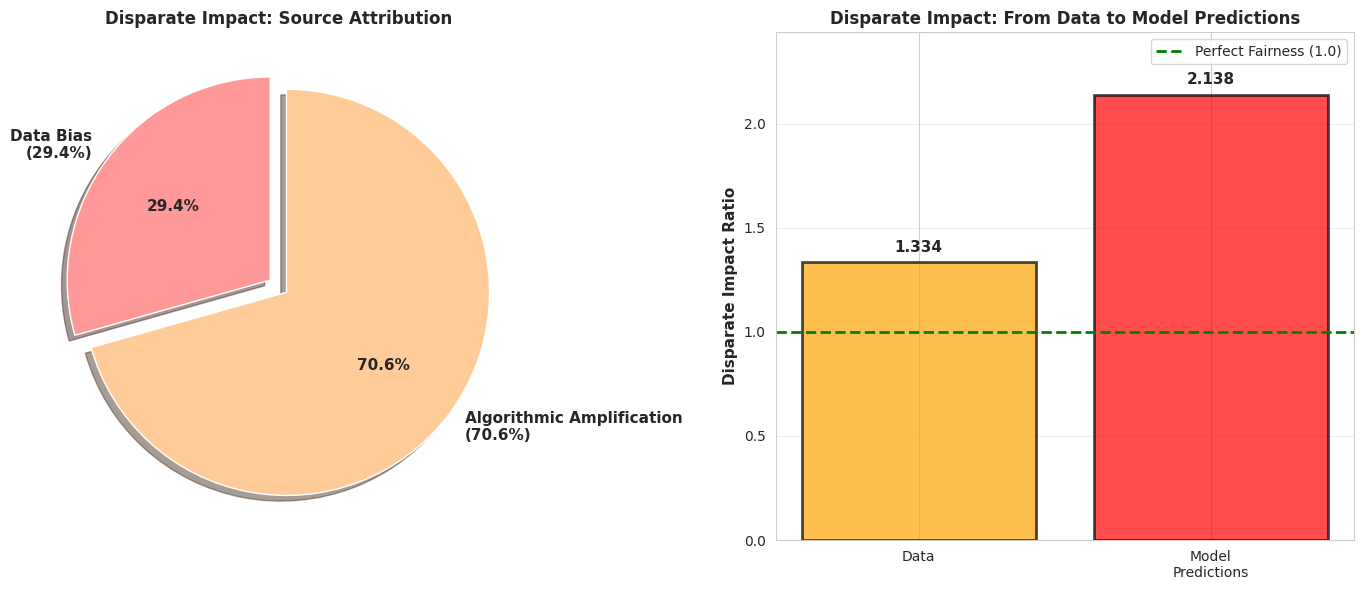

In [27]:
# Visualizing bias decomposition and amplification effects
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

if data_bias_contribution > 0 and algo_bias_contribution > 0:
    sizes = [max(0, data_bias_contribution), max(0, algo_bias_contribution)]
    labels = [f'Data Bias\n({max(0, data_bias_contribution):.1f}%)',
              f'Algorithmic Amplification\n({max(0, algo_bias_contribution):.1f}%)']
    colors = ['#ff9999', '#ffcc99']
    explode = (0.05, 0.05)

    axes[0].pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%',
               shadow=True, startangle=90, textprops={'fontsize': 11, 'fontweight': 'bold'})
    axes[0].set_title('Disparate Impact: Source Attribution', fontweight='bold', fontsize=12)

stages = ['Data\n', 'Model\nPredictions']
dis_values = [baseline_data_di, model_di]
colors_bar = ['orange', 'red']

axes[1].bar(stages, dis_values, color=colors_bar, edgecolor='black', linewidth=2, alpha=0.7)
axes[1].axhline(y=1.0, color='green', linestyle='--', linewidth=2, label='Perfect Fairness (1.0)')
axes[1].set_ylabel('Disparate Impact Ratio', fontweight='bold', fontsize=11)
axes[1].set_title('Disparate Impact: From Data to Model Predictions', fontweight='bold', fontsize=12)
axes[1].set_ylim([0, max(dis_values) + 0.3])
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3, axis='y')

for i, v in enumerate(dis_values):
    axes[1].text(i, v + 0.05, f'{v:.3f}', ha='center', fontweight='bold', fontsize=11)

plt.tight_layout()
plt.show()